<a href="https://colab.research.google.com/github/atharva-ketkar1/DemographicPredictor/blob/main/demographics.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
import os
import cv2
import numpy as np
import pandas as pd
import random
import seaborn as sns
import matplotlib.pyplot as plt
from PIL import Image
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential, Model, load_model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, Input, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical, load_img, img_to_array
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.preprocessing import image
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
!unzip '/content/drive/MyDrive/Demographic Predictor Files/UTKFace.zip';

Streaming output truncated to the last 5000 lines.
  inflating: UTKFace/30_1_0_20170117143902329.jpg.chip.jpg  
  inflating: __MACOSX/UTKFace/._30_1_0_20170117143902329.jpg.chip.jpg  
  inflating: UTKFace/41_0_0_20170116214404363.jpg.chip.jpg  
  inflating: __MACOSX/UTKFace/._41_0_0_20170116214404363.jpg.chip.jpg  
  inflating: UTKFace/58_0_1_20170113193258196.jpg.chip.jpg  
  inflating: __MACOSX/UTKFace/._58_0_1_20170113193258196.jpg.chip.jpg  
  inflating: UTKFace/36_1_1_20170116155035948.jpg.chip.jpg  
  inflating: __MACOSX/UTKFace/._36_1_1_20170116155035948.jpg.chip.jpg  
  inflating: UTKFace/25_0_0_20170113181532013.jpg.chip.jpg  
  inflating: __MACOSX/UTKFace/._25_0_0_20170113181532013.jpg.chip.jpg  
  inflating: UTKFace/66_1_0_20170110123144558.jpg.chip.jpg  
  inflating: __MACOSX/UTKFace/._66_1_0_20170110123144558.jpg.chip.jpg  
  inflating: UTKFace/40_0_1_20170117134411786.jpg.chip.jpg  
  inflating: __MACOSX/UTKFace/._40_0_1_20170117134411786.jpg.chip.jpg  
  inflating: UTKFa

In [4]:
#path = '/content/drive/MyDrive/Demographic Predictor Files/UTKFace'
path = 'UTKFace'
age_labels = []
gender_labels = []
race_labels = []
image_paths = []

images = os.listdir(path)
random.shuffle(images)

for image in images:
  split = image.split("_")
  if len(split) < 4:
    continue
  image_path = os.path.join(path,image)
  age_label = int(split[0])
  gender_label = int(split[1])
  race_label = int(split[2])

  image_paths.append(image_path)
  age_labels.append(age_label)
  gender_labels.append(gender_label)
  race_labels.append(race_label)

In [5]:
print(f'Age Number: {len(age_labels)}, Gender Number: {len(gender_labels)}, Race Number: {len(race_labels)}, Image_Paths: {len(image_paths)}')

Age Number: 23705, Gender Number: 23705, Race Number: 23705, Image_Paths: 23705


In [6]:
df = pd.DataFrame()
df['image_paths'], df['age'], df['gender'], df['race'] = image_paths, age_labels, gender_labels, race_labels

In [7]:
y_age = np.array(df['age'])
y_gender = np.array(df['gender'])
y_race = np.array(df['race'])

# Data Preprocessing

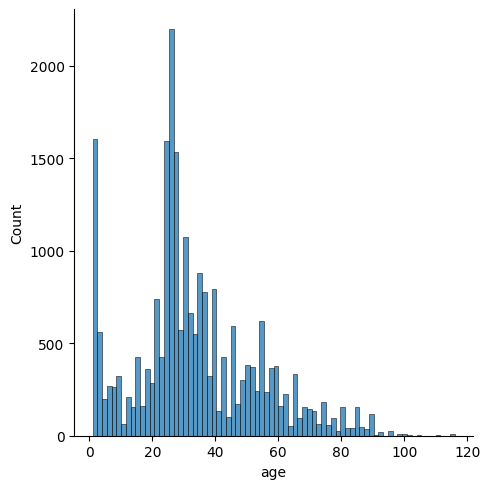

In [8]:
sns.displot(df['age'])

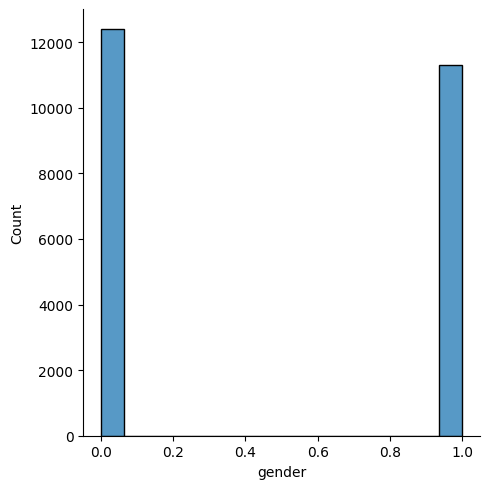

In [9]:
#[gender] is either 0 (male) or 1 (female)
sns.displot(df['gender'])

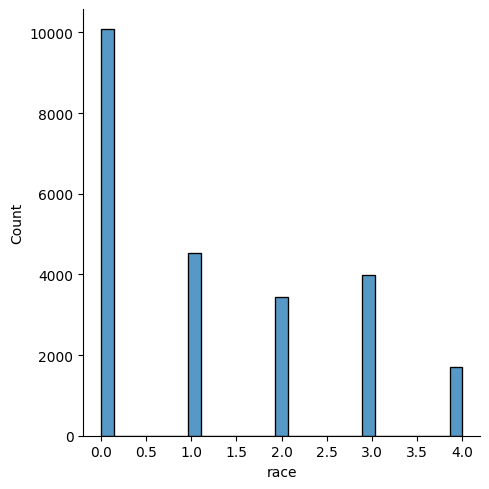

In [10]:
#[race] is an integer from 0 to 4, denoting White, Black, Asian, Indian, and Others (like Hispanic, Latino, Middle Eastern).
sns.displot(df['race'])

##### Age is pretty right skewed, gender has more women than men, and race is very imbalanced. Will have to take this into account during training

# Feature Extraction and Training

In [15]:
def extract_image_features(images):
    features = list()

    for image in images:
        img = load_img(image, color_mode = "grayscale")
        img = img.resize((128, 128), Image.LANCZOS)
        img = np.array(img)
        features.append(img)

    features = np.array(features)
    features = features.reshape(len(features), 128, 128, 1)
    return features

In [16]:
X = extract_image_features(df['image_paths'])
X = X / 255.0

In [19]:
input_shape = (128, 128, 1)

inputs = Input((input_shape))
conv_1 = Conv2D(32, kernel_size=(3, 3), activation='relu')(inputs)
max_1 = MaxPooling2D(pool_size=(2, 2))(conv_1)
conv_2 = Conv2D(64, kernel_size=(3, 3), activation='relu')(max_1)
max_2 = MaxPooling2D(pool_size=(2, 2))(conv_2)
conv_3 = Conv2D(128, kernel_size=(3, 3), activation='relu')(max_2)
max_3 = MaxPooling2D(pool_size=(2, 2))(conv_3)
conv_4 = Conv2D(256, kernel_size=(3, 3), activation='relu')(max_3)
max_4 = MaxPooling2D(pool_size=(2, 2))(conv_4)

flatten = Flatten()(max_4)

# Fully connected layers for age prediction, dropout is added to try to prevent overfitting
dense_age = Dense(256, activation='relu')(flatten)
dropout_age = Dropout(0.3)(dense_age)
output_age = Dense(1, activation='linear', name='age_output')(dropout_age)

# Fully connected layers for gender prediction, dropout is added to try to prevent overfitting
dense_gender = Dense(256, activation='relu')(flatten)
dropout_gender = Dropout(0.3)(dense_gender)
output_gender = Dense(1, activation='sigmoid', name='gender_output')(dropout_gender)

# Fully connected layers for race prediction, dropout is added to try to prevent overfitting
dense_race = Dense(256, activation='relu')(flatten)
dropout_race = Dropout(0.3)(dense_race)
output_race = Dense(5, activation='softmax', name='race_output')(dropout_race)

model = Model(inputs=[inputs], outputs=[output_age, output_gender, output_race])

model.compile(optimizer= 'adam',
              loss=['mae', 'binary_crossentropy', 'categorical_crossentropy'],
              metrics=['accuracy'])

In [20]:
y_race_encoded = to_categorical(y_race, num_classes=5)

history = model.fit(x=X, y=[y_age, y_gender,y_race_encoded],
                    batch_size=32, epochs=50, validation_split=0.2)

Epoch 1/50


/usr/local/lib/python3.10/dist-packages/tensorflow/python/util/dispatch.py:1260: SyntaxWarning: In loss categorical_crossentropy, expected y_pred.shape to be (batch_size, num_classes) with num_classes > 1. Received: y_pred.shape=(None, 1). Consider using 'binary_crossentropy' if you only have 2 classes.
  return dispatch_target(*args, **kwargs)


593/593 [==============================] - 73s 120ms/step - loss: 1.5005 - age_output_loss: 3.9779e-06 - gender_output_loss: 0.4367 - race_output_loss: 1.0638 - age_output_accuracy: 0.0000e+00 - gender_output_accuracy: 0.7851 - race_output_accuracy: 0.6079 - val_loss: 1.1420 - val_age_output_loss: 3.9375e-06 - val_gender_output_loss: 0.3272 - val_race_output_loss: 0.8148 - val_age_output_accuracy: 0.0000e+00 - val_gender_output_accuracy: 0.8511 - val_race_output_accuracy: 0.7051
Epoch 2/50
593/593 [==============================] - 69s 117ms/step - loss: 1.0680 - age_output_loss: 3.9779e-06 - gender_output_loss: 0.3020 - race_output_loss: 0.7660 - age_output_accuracy: 0.0000e+00 - gender_output_accuracy: 0.8656 - race_output_accuracy: 0.7313 - val_loss: 1.0313 - val_age_output_loss: 3.9375e-06 - val_gender_output_loss: 0.3056 - val_race_output_loss: 0.7257 - val_age_output_accuracy: 0.0000e+00 - val_gender_output_accuracy: 0.8654 - val_race_output_accuracy: 0.7488
Epoch 3/50
593/593 [=

In [21]:
model_save_path = '/content/drive/MyDrive/Demographic Predictor Files/models/model.keras'
model_save_path2 = '/content/drive/MyDrive/Demographic Predictor Files/models/model.h5'

# Save the model
model.save(model_save_path)
model.save(model_save_path2)

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [22]:
df['image_paths']

0        UTKFace/39_0_0_20170112215032192.jpg.chip.jpg
1        UTKFace/32_1_1_20170117134806214.jpg.chip.jpg
2         UTKFace/9_0_1_20170110215500987.jpg.chip.jpg
3        UTKFace/52_0_4_20170104184746311.jpg.chip.jpg
4        UTKFace/52_1_0_20170104002309261.jpg.chip.jpg
                             ...                      
23700    UTKFace/24_1_2_20170116174453096.jpg.chip.jpg
23701    UTKFace/13_1_0_20170109204128684.jpg.chip.jpg
23702    UTKFace/18_0_4_20170103201550447.jpg.chip.jpg
23703    UTKFace/53_0_0_20170116232802899.jpg.chip.jpg
23704    UTKFace/32_0_1_20170115230958202.jpg.chip.jpg
Name: image_paths, Length: 23705, dtype: object

1/1 [==============================] - 0s 29ms/step


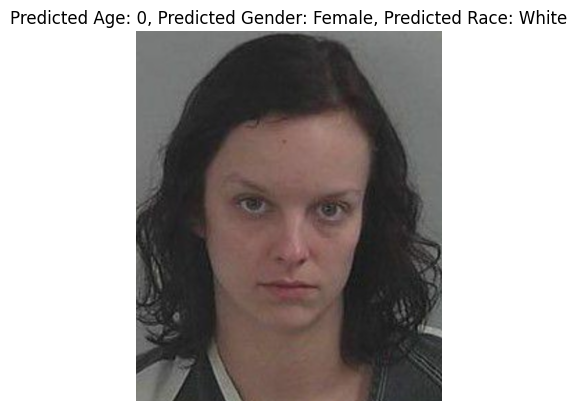

In [41]:
genders = {
    1: 'Female',
    0: 'Male'
}
def get_image_features(image):
  img = load_img(image, grayscale=True)
  img = img.resize((128, 128), Image.LANCZOS)
  img = np.array(img)
  img = img.reshape(1, 128, 128, 1)
  img = img / 255.0
  return img

img_to_test = '/content/drive/MyDrive/Demographic Predictor Files/test_images/4.png'
features = get_image_features(img_to_test)
pred = model.predict(features)
predicted_age = round(pred[0][0][0])
predicted_gender = genders[round(pred[1][0][0])]
predicted_race = np.argmax(pred[2][0][0])
race_labels = ['White', 'Black', 'Asian', 'Indian', 'Hispanic, Latino, Middle Eastern,etc']
predicted_race_label = race_labels[predicted_race]

plt.title(f'Predicted Age: {predicted_age}, Predicted Gender: {predicted_gender}, Predicted Race: {predicted_race_label}')
plt.axis('off')
plt.imshow(np.array(load_img(img_to_test)))

1/1 [==============================] - 0s 29ms/step


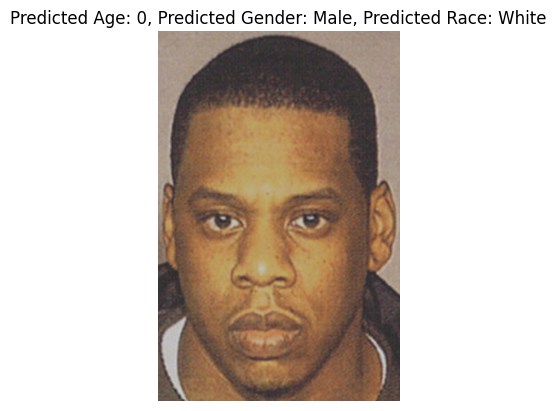

In [42]:
img_to_test = '/content/drive/MyDrive/Demographic Predictor Files/test_images/jayz.jpeg'
features = get_image_features(img_to_test)
pred = model.predict(features)
predicted_age = round(pred[0][0][0])
predicted_gender = genders[round(pred[1][0][0])]
predicted_race = np.argmax(pred[2][0][0])
race_labels = ['White', 'Black', 'Asian', 'Indian', 'Hispanic, Latino, Middle Eastern,etc']
predicted_race_label = race_labels[predicted_race]

plt.title(f'Predicted Age: {predicted_age}, Predicted Gender: {predicted_gender}, Predicted Race: {predicted_race_label}')
plt.axis('off')
plt.imshow(np.array(load_img(img_to_test)))